# ZAIRA

As this wave from memories flows in, the city soaks it up like a sponge and expands. A description of Zaira as it is today should contain all Zaira’s past. The city, however, does not tell its past, but contains it like the lines of a hand, written in the corners of the streets, the gratings of the windows, the banisters of the steps, the antennae of the lightning rods, the poles of the flags, every segment marked in turn with scratches, indentations, scrolls.

In [1]:
from __future__ import print_function

In [2]:
from IPython.display import Image

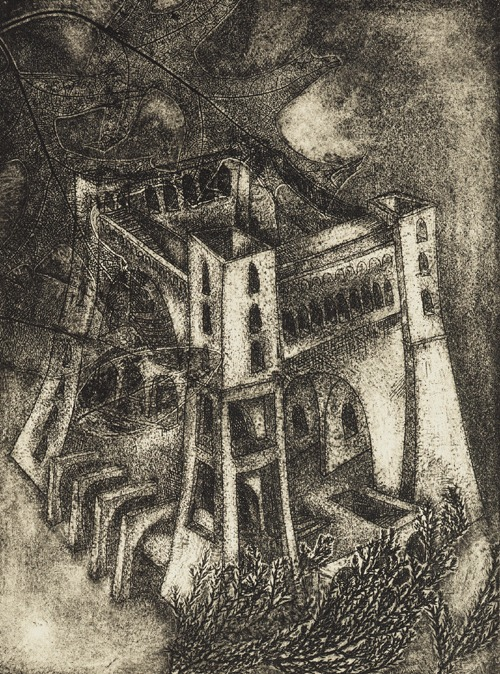

In [3]:
Image(filename='../Images/zaira.jpg') 

### ZAIRA

Objective: produces a file with the SiPM calibration parameters: noise, dark current, gain.

author: Jose A. Hernando
version: v0_00 

### Revision

In [4]:
import time
print(time.strftime("%d/%m/%Y"),' ',time.strftime("%H:%M:%S"))

29/10/2016   17:00:18


### Dependencies

In [5]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [6]:
import numpy as np
import tables
import pandas as pd
import time

In [7]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.mlab import griddata
matplotlib.style.use('ggplot')

In [8]:
pp = %env PYTHONPATH
print(pp)
#from Nh5 import *

/Users/hernando/Software/root/lib:/Users/hernando/Software/lib:/Users/hernando/Investigacion/NEXT/NEXT-Reco/icnew/IC/Core:/Users/hernando/Investigacion/NEXT/NEXT-Reco/icnew/IC/Config:/Users/hernando/Investigacion/NEXT/NEXT-Reco/icnew/IC/Sierpe


### DB  

In [10]:
icdat = '/Users/hernando/Investigacion/NEXT/NEXT-Reco/icnew/Data/NEWMC/'
ifdat = 'nexus_NEW_NEXT_v0_08_00_Kr_ACTIVE_5bar_1000kev_0.next_10000.root.h5'
h5in =tables.open_file(icdat+ifdat,'a')

In [11]:
# the sipm raw data table (all events)
sipmrd = h5in.root.sipmrd
# number of events, sipms, and w.f.length
nevts,nsipms,nshapes = sipmrd.shape[0],sipmrd.shape[1],sipmrd.shape[2]
print('number of events {}, number of sipms {}, wf length {}'.format(nevts,nsipms,nshapes))

# DB position of the (ordered) SiPMs 
sipmdb = h5in.root.Sensors.DataSiPM
print('DB for a SIPM index {}, {}'.format(0,sipmdb[0]))
h5index_of_sensorid = {sipmdb[i][0] : i for i in range(nsipms) }
i0 = sipmdb[0][0]
print('h5index of sensor id [{}]={}'.format(i0,h5index_of_sensorid[i0]))

def sipm_position_of_sensorid(senid):
    if (not h5index_of_sensorid.has_key(senid)): return [-200.,-200,0.]
    h5index = h5index_of_sensorid[senid]
    pos = sipmdb[h5index][2]
    return pos

senid=1000
pos = sipm_position_of_sensorid(senid)
print('position of sensor id {} = {}'.format(senid,pos))

number of events 1000, number of sipms 1789, wf length 1200
DB for a SIPM index 0, (1000, 1, [-235.0, 45.0, -10000.0], 1.0, 15.5)
h5index of sensor id [1000]=0
position of sensor id 1000 = [  -235.     45. -10000.]


### SiPM calibration data

In [12]:
indir='/Users/hernando/Investigacion/NEXT/NEXT-Reco/icnew/Data/NEW/sipmcalib/160923/'
irun='2105'
infile='sipmCal_singlePulse_R'+irun

In [13]:
# input calibration data: dark current and led
import calib as sc
called = sc.CalData(indir+infile+'_led.txt')
caldark = sc.CalData(indir+infile+'_dark.txt')

loaded calibration data from file /Users/hernando/Investigacion/NEXT/NEXT-Reco/icnew/Data/NEW/sipmcalib/160923/sipmCal_singlePulse_R2105_led.txt
number of sensors with data 1792
loaded calibration data from file /Users/hernando/Investigacion/NEXT/NEXT-Reco/icnew/Data/NEW/sipmcalib/160923/sipmCal_singlePulse_R2105_dark.txt
number of sensors with data 1792


In [14]:
# create pdf file to put the figures
from matplotlib.backends.backend_pdf import PdfPages
pdf = None

In [15]:
def position_of_indexes(indexes):
    senids = map(sc.sipm_sensorid_of_index,indexes)
    pos = map(sipm_position_of_sensorid,senids)
    return np.array(pos)

In [16]:
# take the reference values
xbins = called.xbins
indexes = called.indexes
positions = position_of_indexes(indexes)

## Calibration

### calibration to poisson and ngaussians

In [17]:
#chi2,pss = sc.cal_fit_ngauss(called,indexes,ngauss=7)
chi2,pss = sc.cal_fit_poissongauss(called,indexes,ngauss=7)
zpss = zip(indexes,pss)

fitting data...
fitting data...
fitting data...
fitting data...
fitting data...
fitting data...
fitting data...
fitting data...
fitting data...


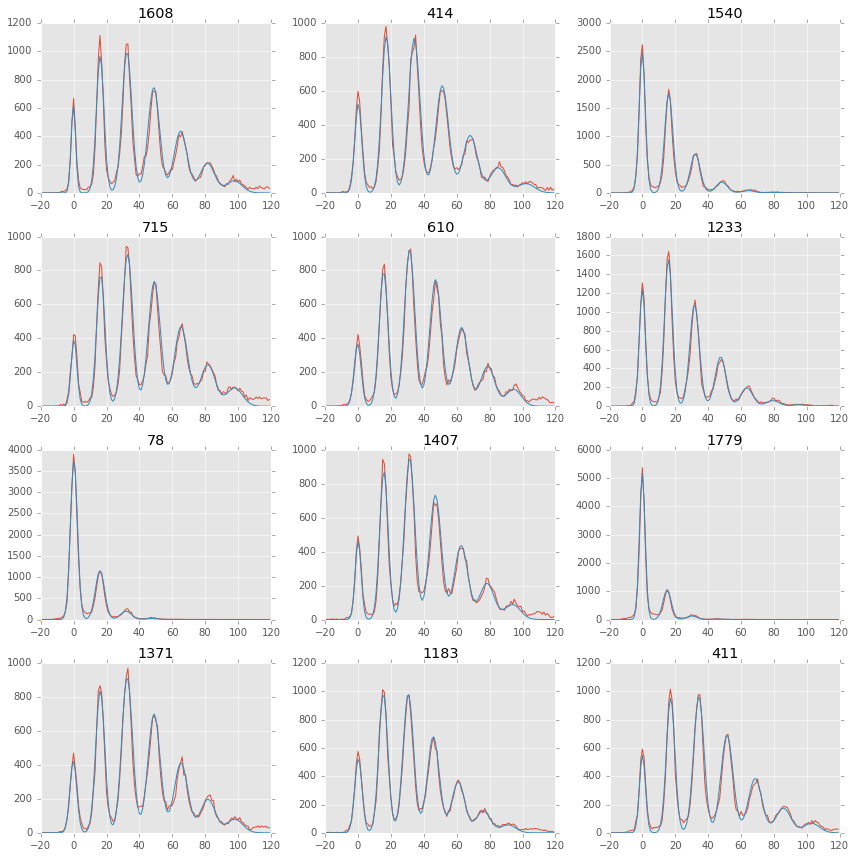

In [20]:
pdf = None
pdf = PdfPages(indir+'calf_R'+irun+'_pg_fits.pdf')
fun = sc.ffun_poissongauss
fig = sc.polo_cal_fit(called,indexes[:12],pss[:12],fun,xrange=(-20.,120.))
if (pdf): pdf.savefig(fig)
pdf.close()

In [21]:
pan = sc.cal_fit_poissongauss_panda(indexes, chi2, pss)

In [22]:
pan.describe()

chi2         gain      indexes        noise     noise-pe  \
count  1792.000000  1792.000000  1792.000000  1792.000000  1792.000000   
mean      6.401254    16.216835   895.500000     1.932562     1.777431   
std       2.449360     0.860911   517.450159     0.503952     0.351704   
min       0.499482    12.000000     0.000000     1.115738     0.500000   
25%       4.686043    15.781343   447.750000     1.581589     1.669757   
50%       5.970026    16.167188   895.500000     1.837369     1.758753   
75%       7.698864    16.650074  1343.250000     2.120319     1.850804   
max      16.990538    29.725845  1791.000000     5.889240    10.000000   

               ntot     pedestal           pes  
count   1792.000000  1792.000000  1.792000e+03  
mean   28923.937943     0.215051  2.024412e+00  
std      396.836821     0.670732  8.417044e-01  
min    27351.154452    -1.073112  6.440806e-08  
25%    28716.519871    -0.113866  1.660217e+00  
50%    29012.232485    -0.008450  2.349864e+00  
75%    29203.843556     0.185064  2.653863e+00  
max    29939.026665     4.217113  3.250433e+00

In [24]:
pan.to_hdf(indir+'calf_R'+irun+'_pg_panda.h5','df',mode='w',format='table',data_columns=True)
pan.to_csv(indir+'calf_R'+irun+'_pg_panda.csv')

## Plotting

### Plotting parameters

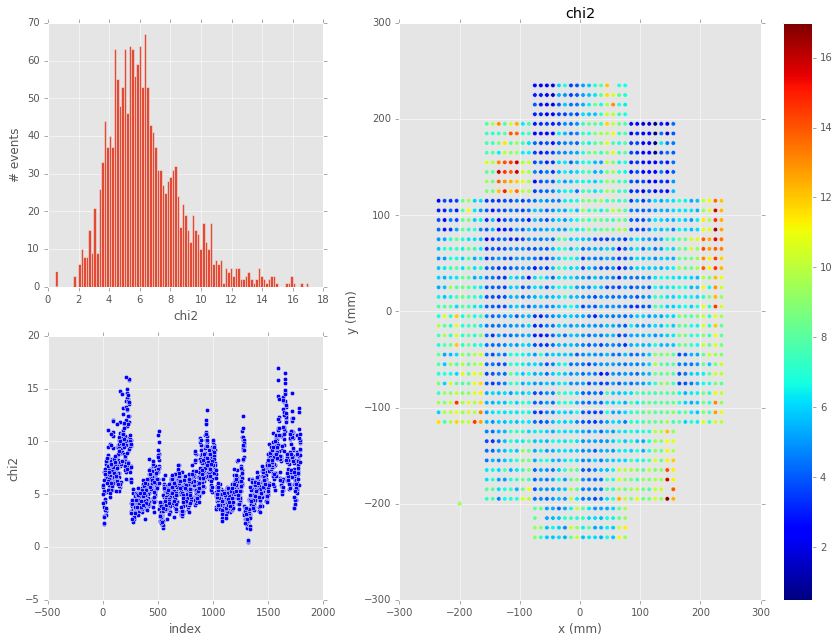

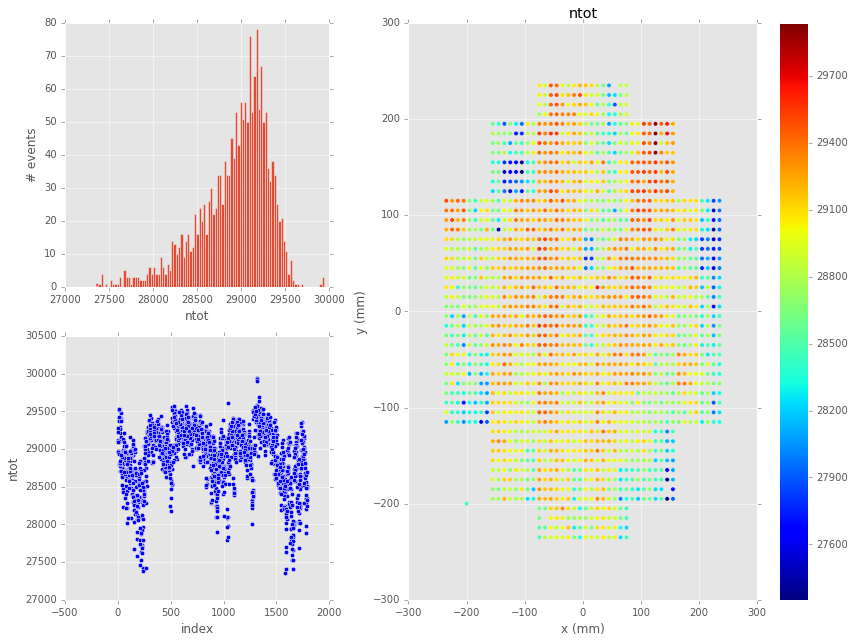

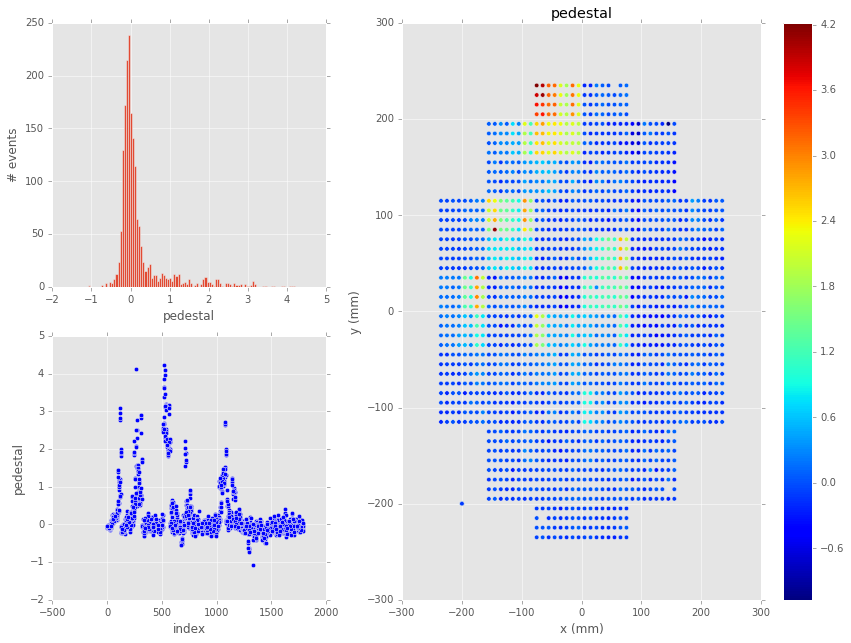

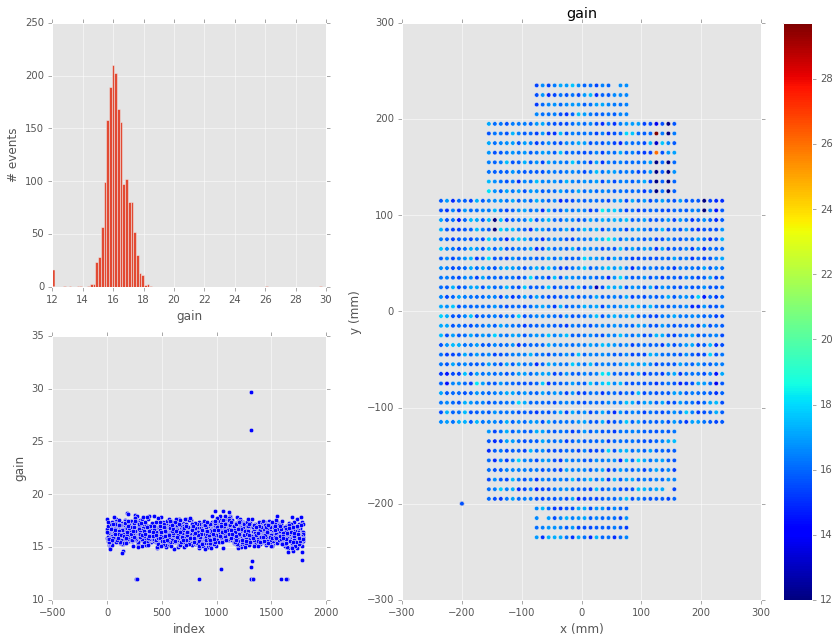

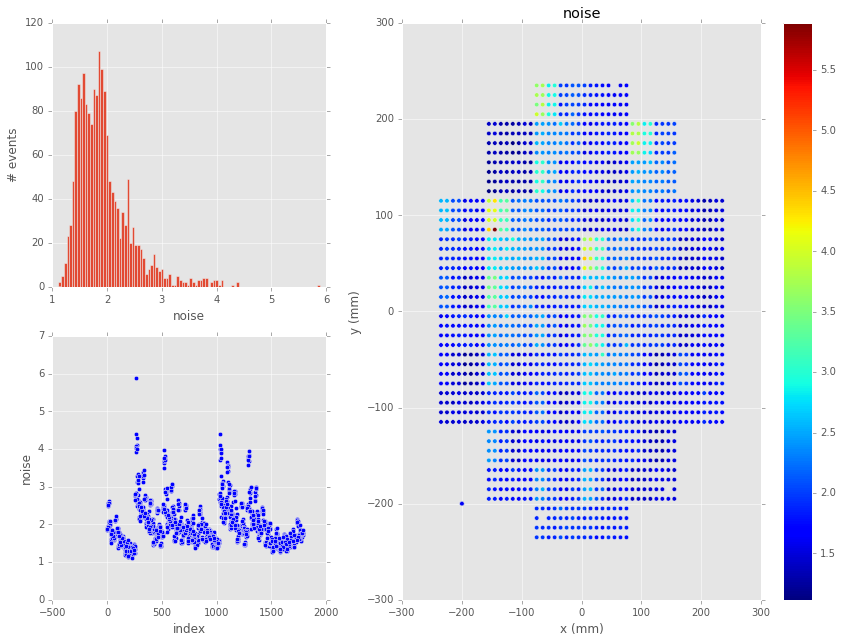

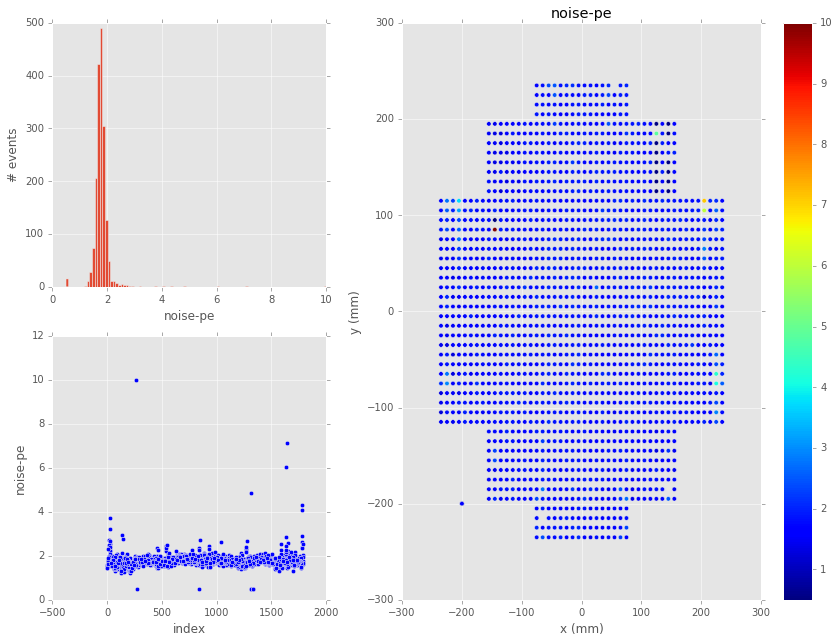

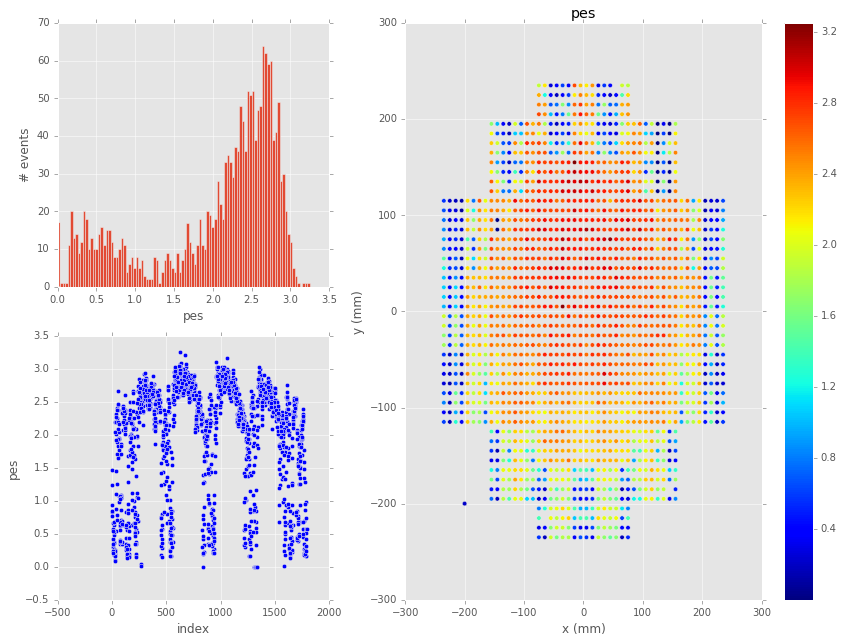

In [25]:
pdf = None
pdf = PdfPages(indir+'calf_R'+irun+'_pg_figs.pdf')
labels = ['chi2','ntot','pedestal','gain','noise','noise-pe','pes']
for label in labels:
    fig = sc.polo_pars(pan['indexes'],pan[label],positions,label=label)
    if (pdf): pdf.savefig(fig)
pdf.close()

In [26]:
zpss = zip(indexes,pss)
def pss_filter(findexes,zpss):
    ixs = list(findexes)
    fzs = filter(lambda z: z[0] in ixs,zpss)
    fpss = map(lambda z: z[1],fzs)
    return fpss

In [27]:
### Plotting SiPM spectrum of SiPMs with parameters in the tails of the distributions

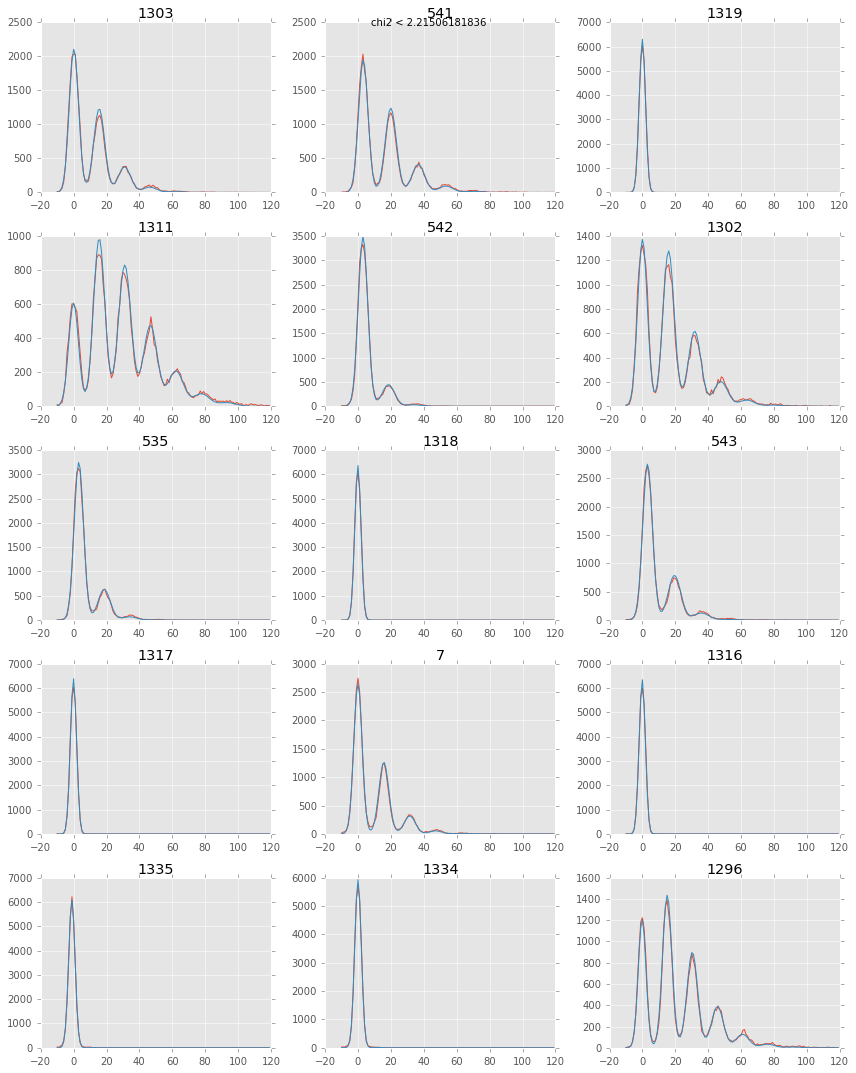

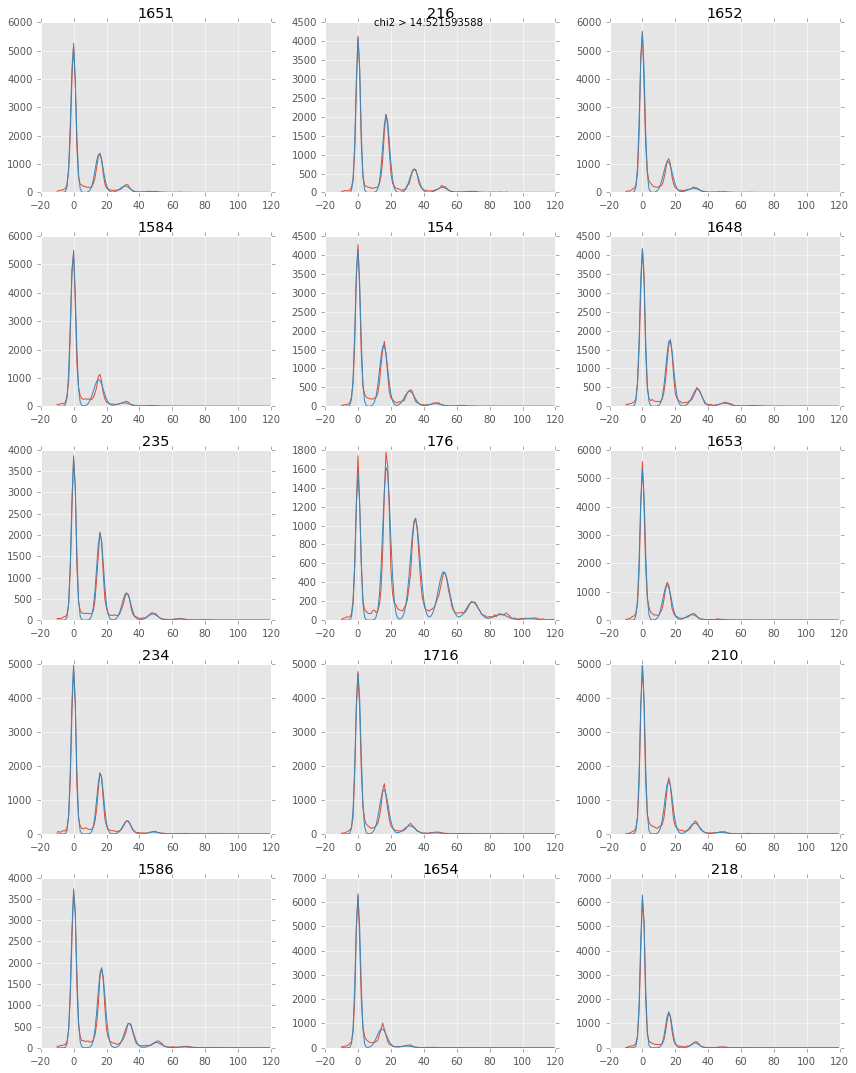

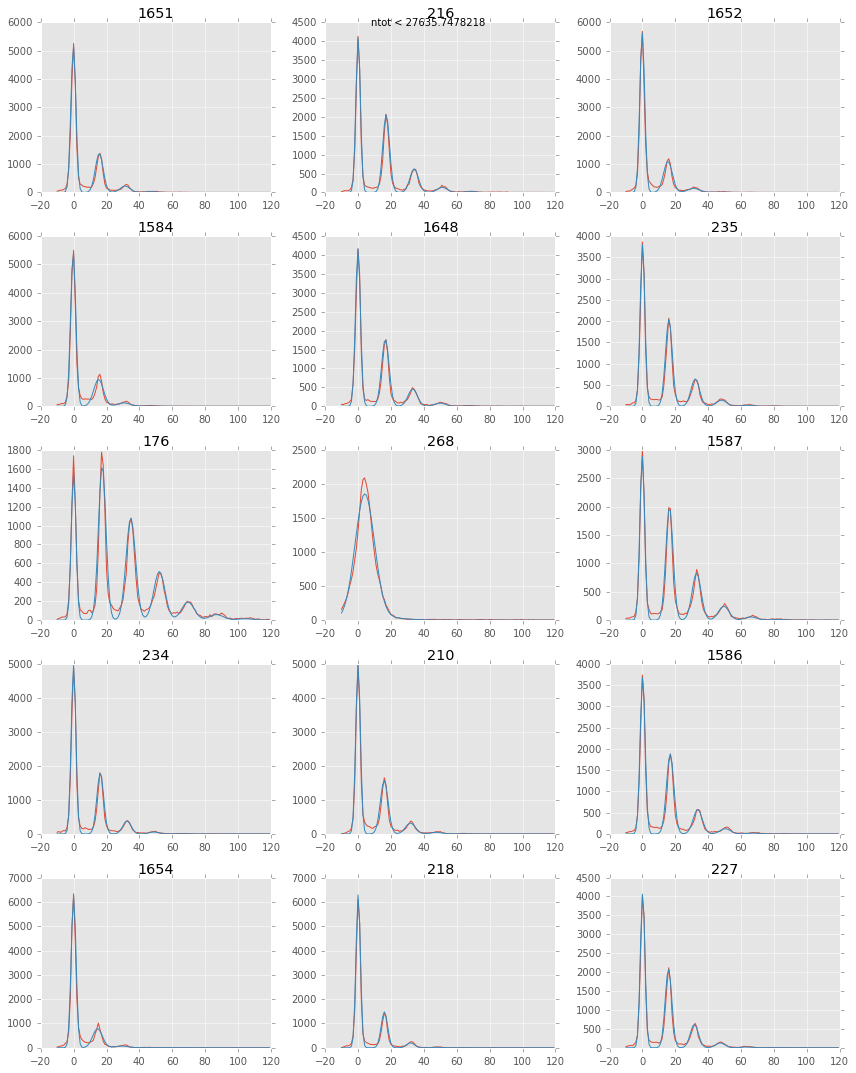

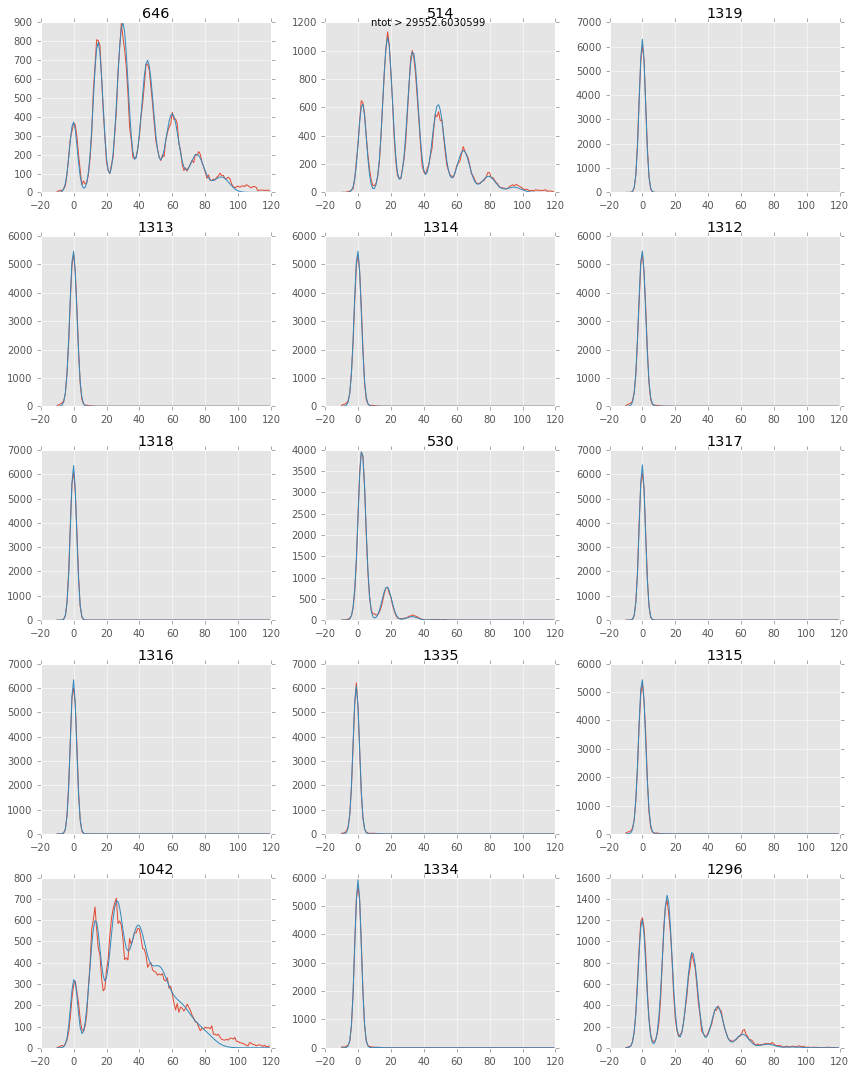

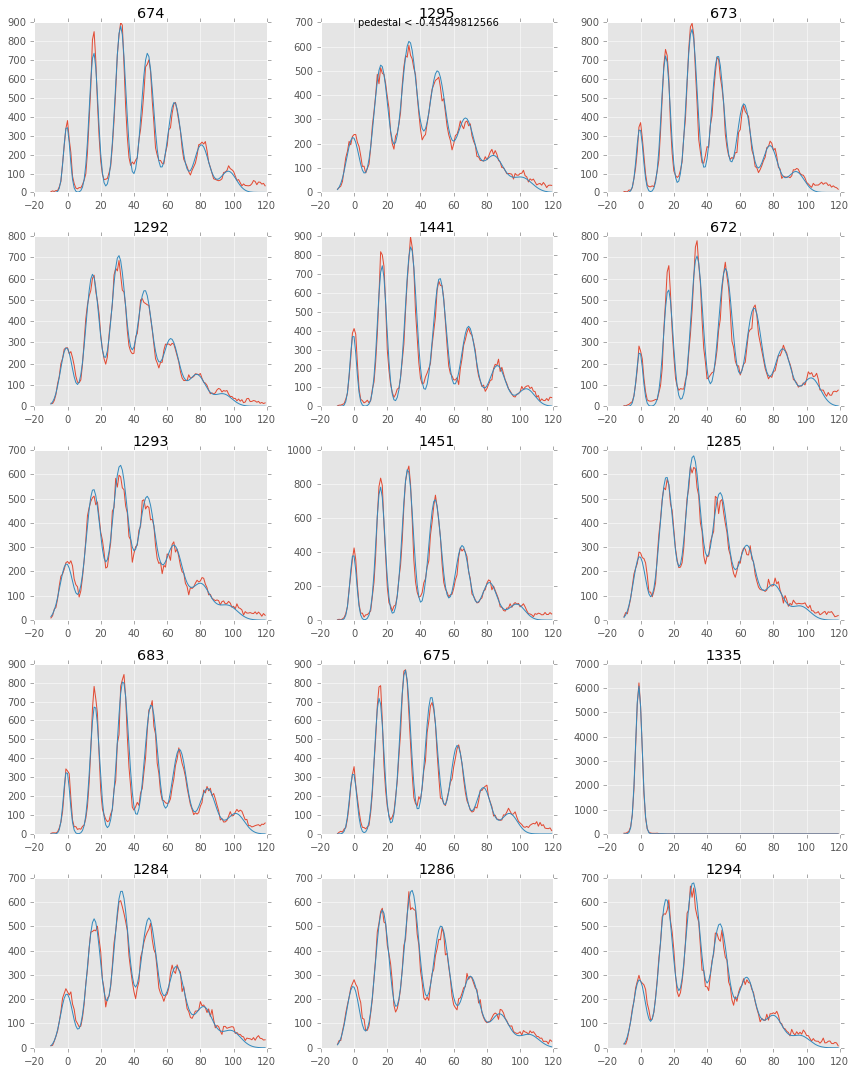

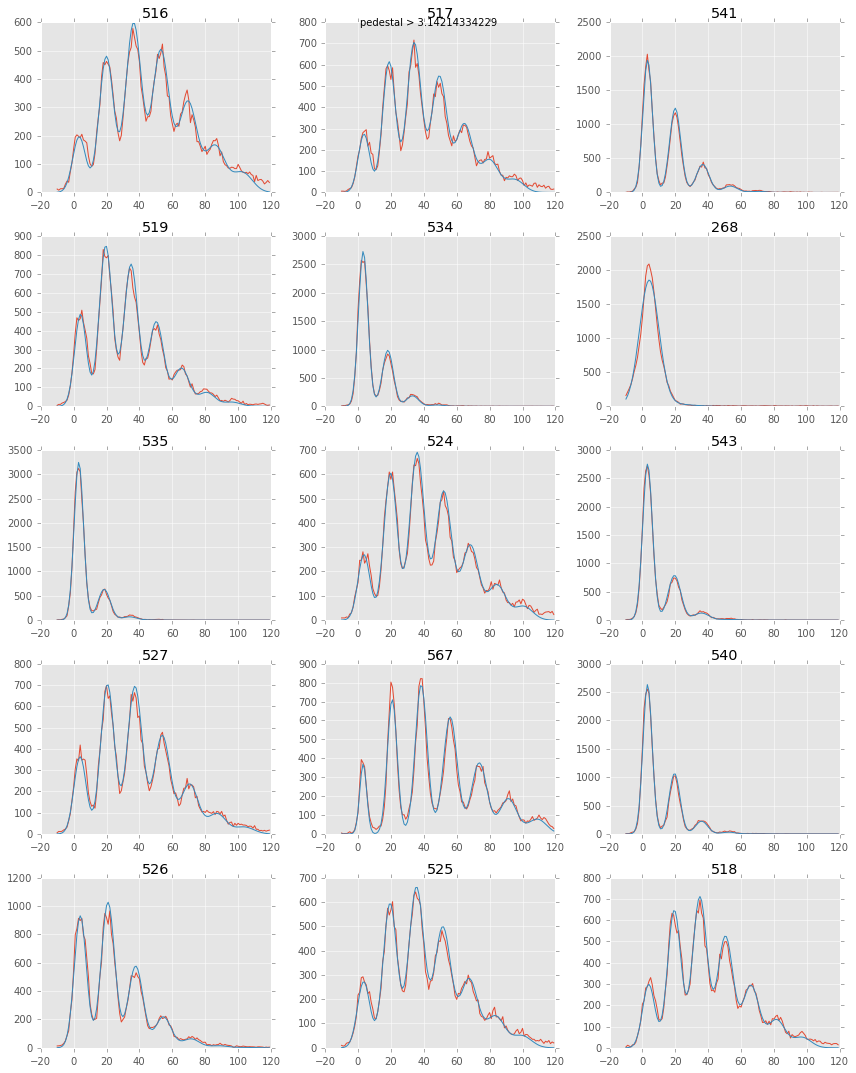

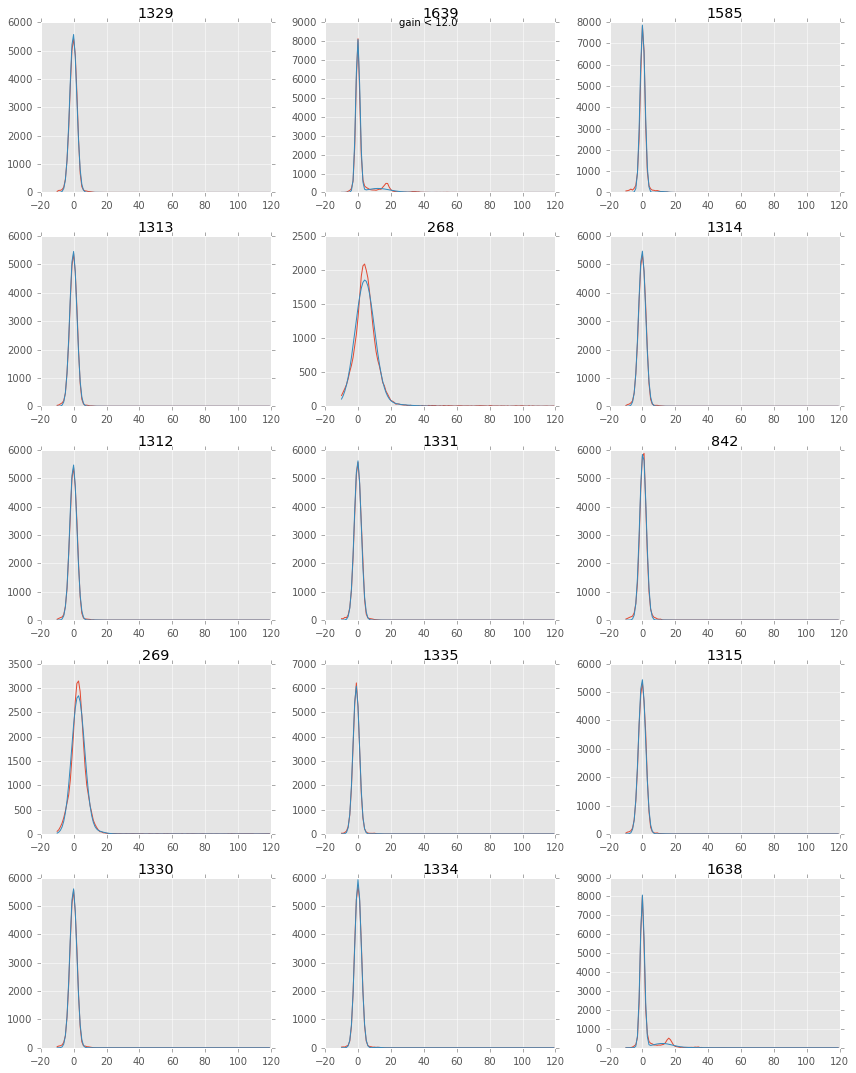

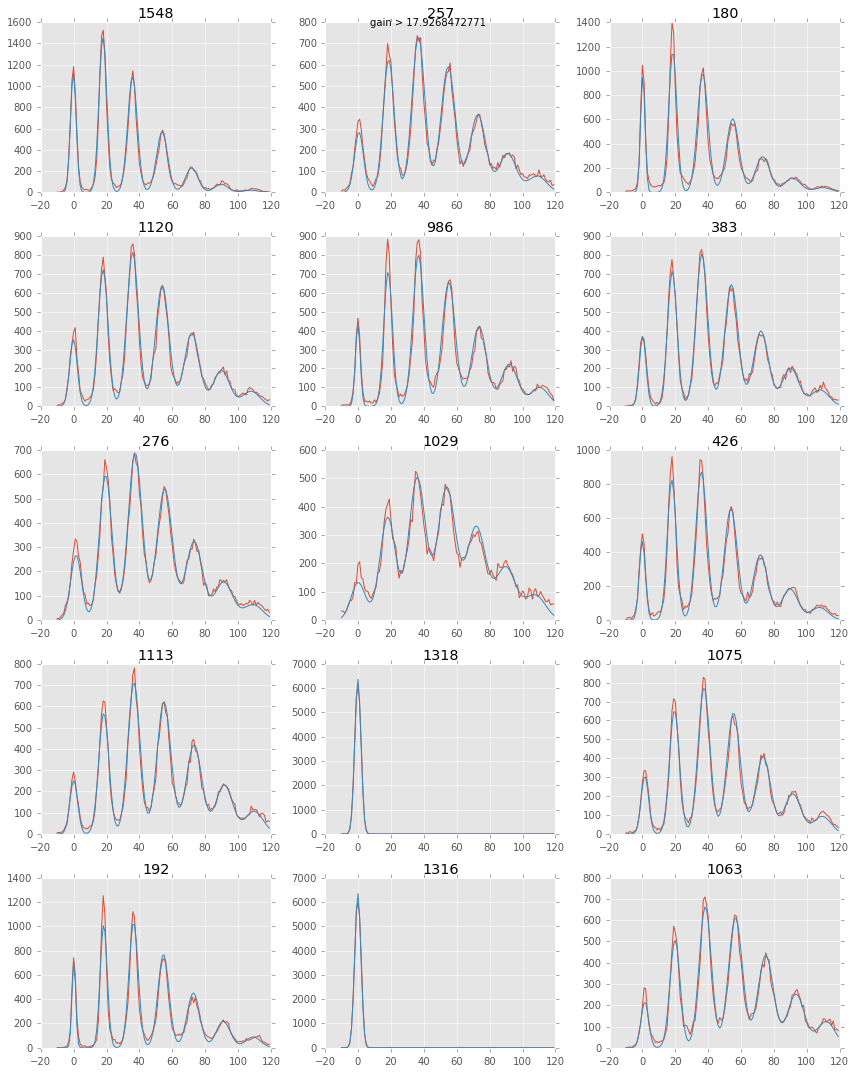

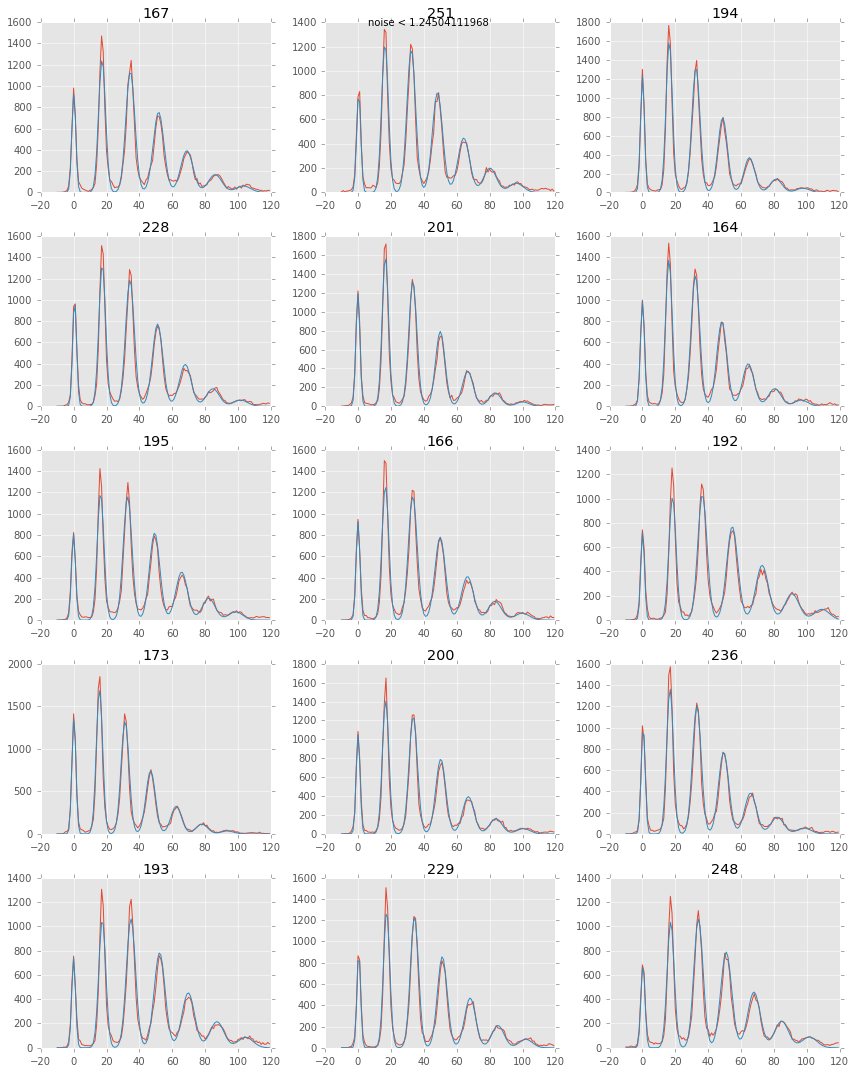

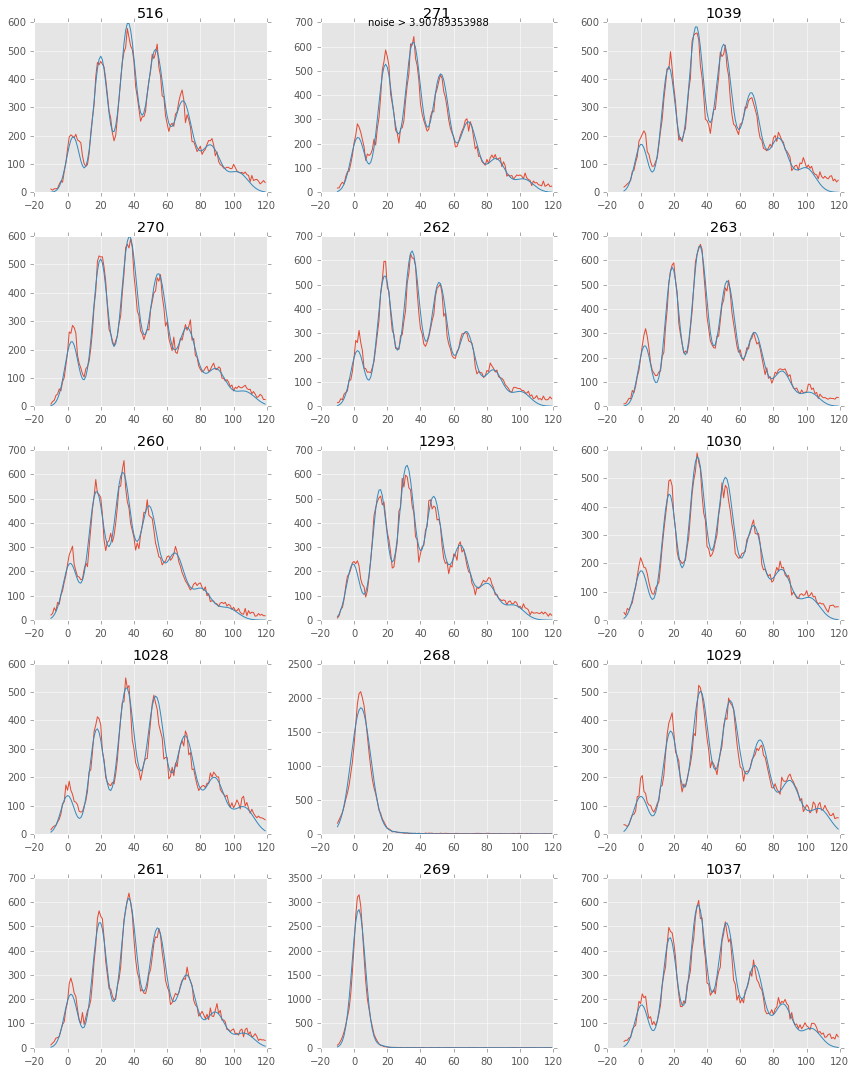

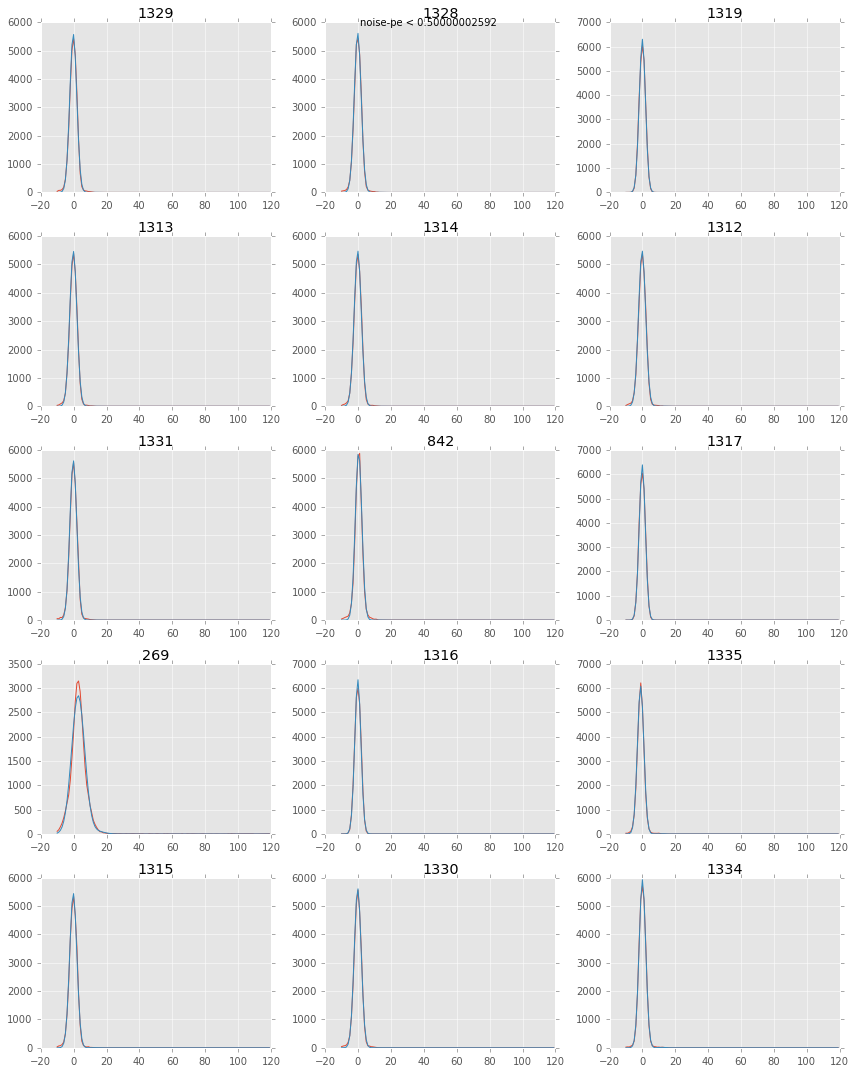

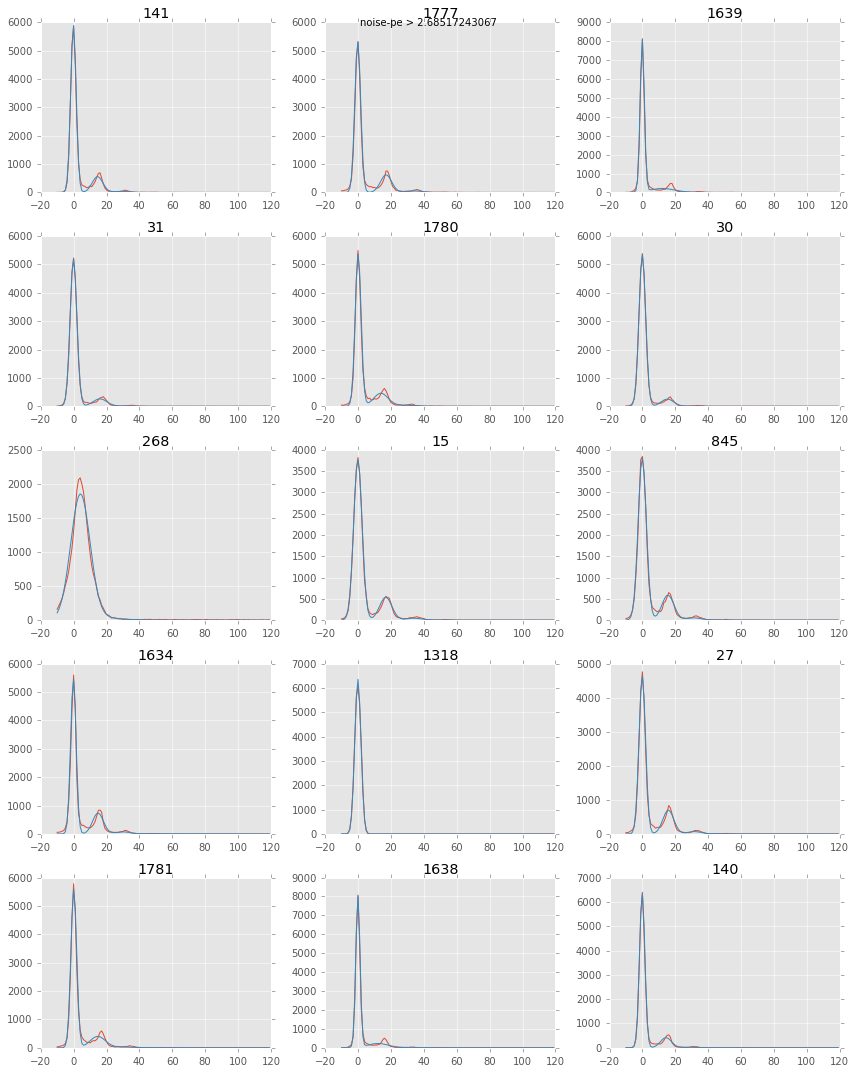

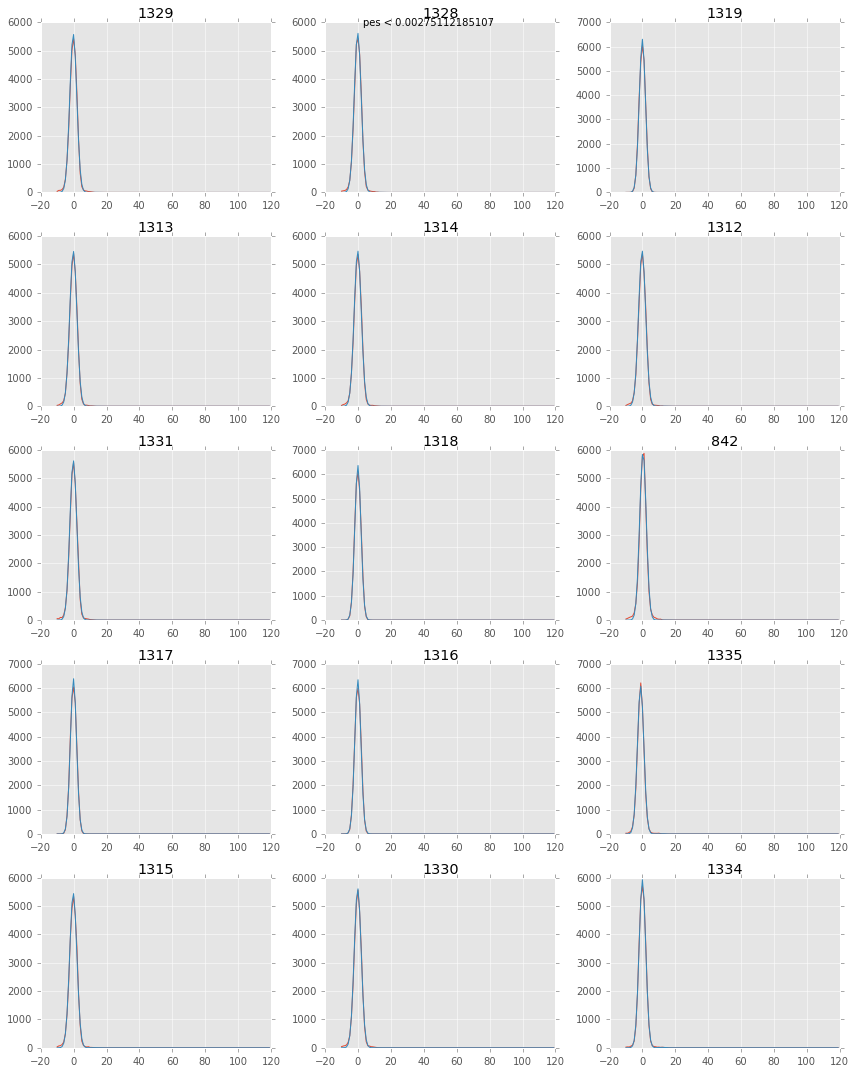

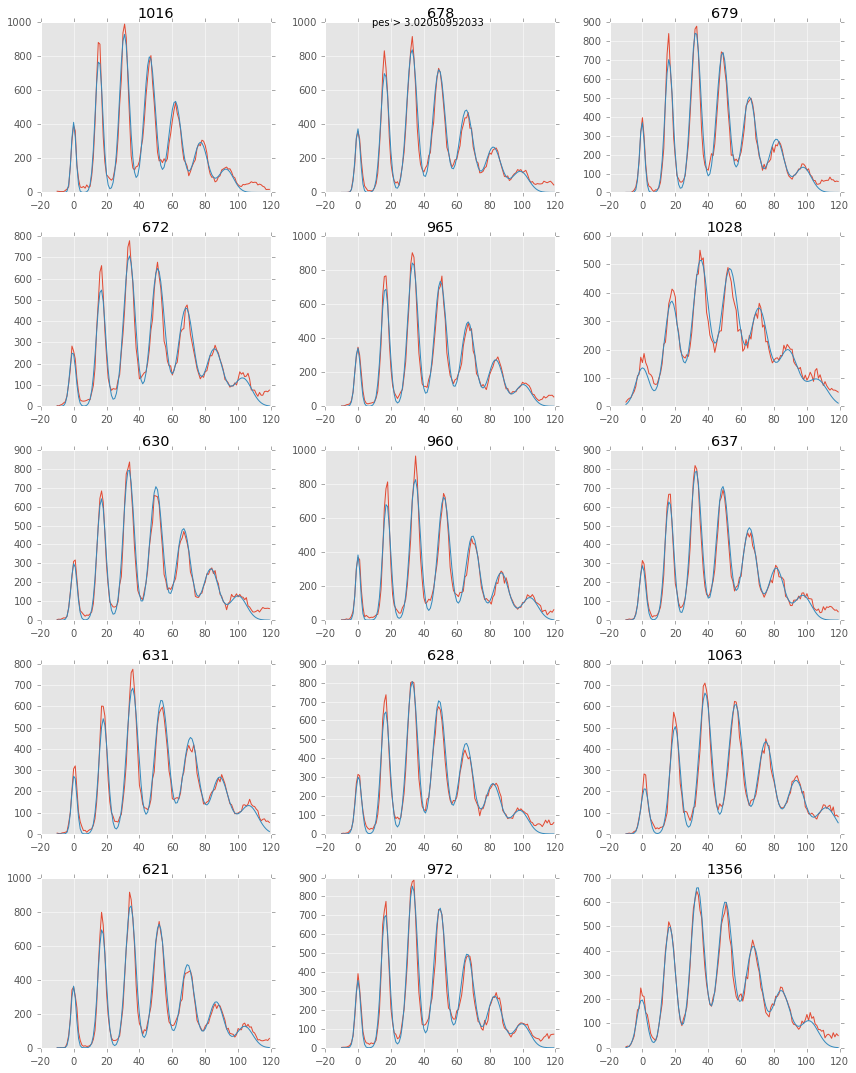

In [28]:
labels=['chi2','ntot','pedestal','gain','noise','noise-pe','pes']
percentile=0.008

pdf = PdfPages(indir+'calf_R'+irun+'_pg_figs_tails.pdf')

for label in labels:
    val0,valf = sc.np_percentile(pan[label],percentile=percentile)
    fpan = pan[pan[label]<=val0]
    findexes = fpan['indexes']
    fpss = pss_filter(findexes,zpss)
    title = label+' < '+str(val0)
    fig = sc.polo_cal_fit(called,findexes,fpss,fun,xrange=(-10.,120.),title=title)
    if (pdf): pdf.savefig(fig)
    fpan = pan[pan[label]>=valf]
    findexes = fpan['indexes']
    fpss = pss_filter(findexes,zpss)
    title = label+' > '+str(valf)
    fig = sc.polo_cal_fit(called,findexes,fpss,fun,xrange=(-10.,120.),title=title)
    if (pdf): pdf.savefig(fig)
        
pdf.close()
#    fpan
#    raw_input('enter key')

That's all folks!